# PME3531 - Mecânica dos Fluidos Aplicada a Sistemas Vasculares
# Modelo computacional para geração de vasculatura

## Resumo do funcionamento

- **Definição da uma malha equivalente ao espaço físico modelado**

  - Aplicação de máscaras à malha para delimitar a região da vasculatura

- **Inicialização das estruturas e parâmetros físicos do modelo, a partir de dados iniciais fornecidos**

  - Inicialização de matrizes e listas para armazenar as propriedades da vasculatura
  
  - Configuração inicial de vasos
  
- **Adição iterativa de novos vasos ao modelo inicial**

  - Seleção de uma nova região terminal a partir de uma máscara de probabilidade
  
  - Seleção do segmento de vaso mais apropriado para ramificação até a nova região terminal
  
  - Ramificação do segmento de vaso escolhido, utilizando os princípios físicos e hipóteses adotadas
  
  - Atualização das matrizes e listas de propriedades da vasculatura

## Bibliotecas utilizadas

In [1]:
# Para a malha:
import numpy as np

# Para a apresentação dos resultados:
import matplotlib.pyplot as plt

# Bibliotecas auxiliares
from vasculature.helpers import get_index, get_position, get_vector, get_vector_length, point_line_distance, quadratic_solver, setup_plot, plot_vasculature
from vasculature.masks import block_mask, cylinder_mask
from time import time

use_widget = False

## Definição da malha

### Malha inicial

In [2]:
# Em 2D:

N_mesh = [40, 40]                      # Resolução da malha
L      = [10, 10]                      # Dimensões reais do espaço modelado
dL     = [L[i]/(N_mesh[i] - 1)         # Passo da malha
          for i in range(len(N_mesh))]

M_base = np.ones(N_mesh)

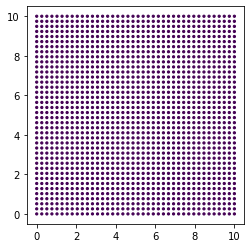

In [3]:
if use_widget:
    %matplotlib widget
fig = plt.figure('Malha inicial')
ax, grid = setup_plot(fig, L, N_mesh, True)
ax.scatter(*grid, c=M_base, s=np.ones(N_mesh)*5)

### Máscaras

**Máscara elipsoidal**

$$
\frac{(x - x_c)^2}{a^2} + \frac{(y - y_c)^2}{b^2} + \frac{(z - z_c)^2}{c^2} \le 1
$$

In [4]:
def ellipsoid_mask(shape, h, ranges):
    # ranges => [[centre_x, R_x], [centre_y, R_y], [centre_z, R_z]]
    dimensions = len(ranges)
    index = [None]*(dimensions - 1)
    mask = np.ones(shape)
    
    def iterator(dimension=0, C=1):
        if dimension == dimensions - 1:
            solution = quadratic_solver(ranges[dimension][0], C*ranges[dimension][1]**2)
            if solution:
                range_start = max(round(solution[0]/h[dimension]), 0)
                range_end = min(round(solution[1]/h[dimension]) + 1, shape[dimension])
                for i in range(range_start, range_end):
                    index_tuple = tuple(index + [i])
                    mask[index_tuple] = 0
        else:
            range_start = max(round((ranges[dimension][0] - ranges[dimension][1])/h[dimension]), 0)
            range_end = min(round((ranges[dimension][0] + ranges[dimension][1])/h[dimension]) + 1, shape[dimension])
            for i in range(range_start, range_end):
                index[dimension] = i
                iterator(dimension + 1, C - ((i*h[dimension] - ranges[dimension][0])/ranges[dimension][1])**2)
                
    iterator()
    return mask

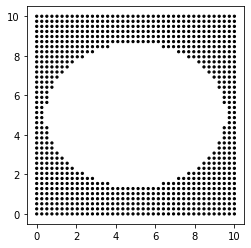

In [5]:
if use_widget:
    %matplotlib widget
fig = plt.figure('Máscara elipsoidal')
ax, grid = setup_plot(fig, L, N_mesh, True)
ax.scatter(*grid, c=ellipsoid_mask(N_mesh, dL, [[5, 4.5], [5, 3.5]]), s=np.ones(N_mesh)*5, cmap='Greys')

**Máscara de salsicha**

$$
\vec{v} = (x_2, y_2, z_2) - (x_1, y_1, z_1)
$$

$$
\vec{u} = (x, y, z) - (x_1, y_1, z_1)
$$

$$
\vec{w} = (x, y, z) - (x_2, y_2, z_2)
$$

$$
k = \frac{\vec{u} \cdot \vec{v}}{|\vec{v}|}
$$

$$
\begin{cases}
    |\vec{u}| \le R & \text{se $k \le 0$}\\
    |\vec{u} - k \vec{v}| \le R & \text{se $0 < k < 1$}\\
    |\vec{w}| \le R & \text{se $1 \le k$}
\end{cases}
$$

In [6]:
def sausage_mask(shape, h, ranges, R):
    # ranges => [[x_1, x_2], [y_1, y_2], [z_1, z_2]]
    # R -> sausage radius
    dimensions = len(ranges)
    index = [None]*dimensions
    mask = np.ones(shape)
    
    def iterator(dimension=0):
        range_start = max(round((min(ranges[dimension]) - R)/h[dimension]), 0)
        range_end = min(round((max(ranges[dimension]) + R)/h[dimension]) + 1, shape[dimension])
        if dimension == dimensions - 1:
            for i in range(range_start, range_end):
                index[dimension] = i
                if point_line_distance(get_position(index, h), *np.transpose(ranges)) <= R:
                    index_tuple = tuple(index)
                    mask[index_tuple] = 0
        else:
            for i in range(range_start, range_end):
                index[dimension] = i
                iterator(dimension + 1)
                
    iterator()
    return mask

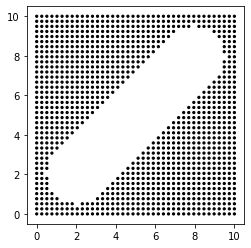

In [7]:
if use_widget:
    %matplotlib widget
fig = plt.figure('Máscara de salsicha')
ax, grid = setup_plot(fig, L, N_mesh, True)
ax.scatter(*grid, c=sausage_mask(N_mesh, dL, [[2, 8], [2, 8]], 1.5), s=np.ones(N_mesh)*5, cmap='Greys')

Aplicando a máscara à malha inicial:

In [8]:
N_mesh = [100, 100]                    # Resolução da malha
L      = [10, 10]                      # Dimensões reais do espaço modelado
dL     = [L[i]/(N_mesh[i] - 1)         # Passo da malha
          for i in range(len(N_mesh))]

M_base = np.ones(N_mesh)
mask = ellipsoid_mask(N_mesh, dL, [[5, 5], [5, 5]])

M = M_base - mask

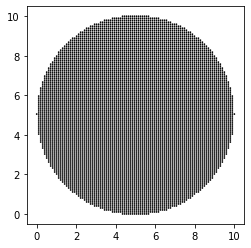

In [9]:
if use_widget:
    %matplotlib widget
fig = plt.figure('Máscara da região modelada')
ax, grid = setup_plot(fig, L, N_mesh, True)
ax.scatter(*grid, c=M, s=np.ones(N_mesh)*0.5, cmap='Greys')

## Inicialização das matrizes e listas de propriedades

Com os dados de entrada X_in, X_out, X_term, P_in, P_out, P_term e f_term, inicializam-se dois conjuntos de listas de propriedades, um para os vasos de entrada e outro para os de saida.

Para os vasos de entrada:

|    |nodes_in|pressures_in|
|:--:|:---:|:-------:|
|0   |X_in|P_in|
|1   |X_term|P_term|
|... |...|...     |
|n   |...|...     |

|    |segments_in|parents_in|children_in|flows_in|radii_in|
|:--:|:------:|:-----:|:------:|:---:|:---:|
|0   |[0, 1]|None|[None, None]|F_term|*get_radius(...)*|
|... |...      |... |...   |...   |...  |
|m   |...      |... |...   |...   |...  |

Representação dos nós de entrada:

<img src="./imagens/img1.png"/>

Representação das listas iniciais derivadas dos nós de entrada:

<img src="./imagens/img2.png"/>
<img src="./imagens/img3.png"/>

In [10]:
# Dados de entrada
X_in  = [0 , 5]
X_out = [10, 5]
X_term = [5, 6]
P_in = 4000
P_out = 0
P_term = 2000
f_term = 0.2

# Propriedades derivadas dos dados fornecidos
dV = np.prod(dL)
F_term = f_term*dV

# Inicialização das listas
#   Para os nós de entrada
nodes_in = [get_index(X_in, dL), get_index(X_term, dL)]
pressures_in = [P_in, P_term]
#   Para os nós de saída
nodes_out = [get_index(X_out, dL), get_index(X_term, dL)]
pressures_out = [P_out, P_term]
#   Para os segmentos de entrada
segments_in = [[0, 1]]
parents_in = [None]
children_in = [[None, None]]
flows_in = [F_term]
#   Para os segmentos de saída
segments_out = [[0, 1]]
parents_out = [None]
children_out = [[None, None]]
flows_out = [F_term]

Para o cálculo do raio, utiliza-se a equação derivada do artigo *Generating Blood Vasculature for Bioheat Computations*:

$$
R = \left(\frac{8 \cdot \eta \cdot F \cdot L}{\pi \cdot \Delta P}\right)^{0.25}
$$

Com $\eta = 3.5\text{e}-3$:

$$
R = 0.2956 \cdot \left(\frac{F \cdot L}{\Delta P}\right)^{0.25}
$$

In [11]:
def get_radius(Fn, Ln, dP):
    # dP = abs(P_1 - P_2)
    # eta = 3.5e-3 -> (8*eta/pi)^(0.25) = 0.29564146
    return 0.29564146*(Fn*Ln/dP)**0.25

def update_radius(R_i, F_i, f):
    # Regra de três
    return R_i*(1 + f/F_i)**0.25

In [12]:
# Inicialização das listas dos raios
radii_in = [get_radius(F_term, get_vector_length(get_vector(X_in, X_term)), P_in - P_term)]
radii_out = [get_radius(F_term, get_vector_length(get_vector(X_out, X_term)), P_term - P_out)]

Com as listas inicializadas, gera-se uma nova máscara de exclusão para evitar que a próxima região terminal escolhida esteja muito próxima dos vasos já existentes.

Aplicando-se essa máscara à malha inicial, cria-se uma máscara de probabilidade para a seleção estocástica da próxima região terminal

Adotou-se que a distribuição de fluxo na região modelada é constante.

In [13]:
def generate_mask(N_mesh, dL, e, nodes, segments, **kwargs):
    # Gera a região onde haverá vascularização dentro da malha
    # Utiliza máscaras de "salsicha"
    mask = np.ones(N_mesh)
    for segment in segments:
        mask *= sausage_mask(N_mesh, 
                             dL, 
                             np.transpose([get_position(nodes[node_index], dL) 
                                           for node_index in segment]), 
                             e)
    return mask

In [14]:
mask_in = generate_mask(N_mesh, dL, 0.2, nodes_in, segments_in)
mask_out = generate_mask(N_mesh, dL, 0.2, nodes_out, segments_out)

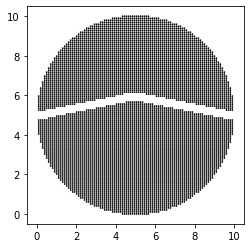

In [15]:
if use_widget:
    %matplotlib widget
fig = plt.figure('Pontos disponíveis para escolha de região terminal')
ax, grid = setup_plot(fig, L, N_mesh, True)
ax.scatter(*grid, c=M*mask_in*mask_out, s=np.ones(N_mesh)*0.5, cmap='Greys')

## Adição iterativa de novos vasos

### Seleção de uma nova região terminal

Utilizando a máscara de probabilidade, uma nova região terminal é escolhida

In [16]:
def roll_terminal_node(probability_mask):
    # Seleciona aleatoriamente um nó terminal com base na máscara de probabilidade fornecida.
    # node_index -> [x, y, z] (indices)
    shape = probability_mask.shape
    size = np.prod(shape)
    nodes = np.random.choice(np.arange(size), 1, False, probability_mask.flatten())
    node_index = tuple(np.vstack(np.unravel_index(nodes, shape)).T[0])
    return node_index

### Seleção do segmento de vaso apropriado

A partir do novo nó e das listas de propriedades, seleciona-se o segmento de vaso mais próximo da região terminal

In [17]:
def find_closest_segment(node, nodes, segments):
    # Retorna o indice do segmento mais próximo ao nó fornecido.
    min_distance = 0
    closest_segment_index = None
    for segment_index in range(len(segments)):
        distance = point_line_distance(node, *[nodes[node_index] 
                                               for node_index in segments[segment_index]])
        if distance < min_distance or not min_distance:
            min_distance = distance
            closest_segment_index = segment_index
    return closest_segment_index

### Otimização da ramificação

Com o nó da região terminal e o segmento de vaso escolhidos, a geometria do vaso ramificado resultando é otimizado, buscando o menor volume de vascularização.

Para essa otimização, são utilizados os princípios físicos e hipóteses adotadas no artigo *Generating Blood Vasculature for Bioheat Computations*.

In [18]:
def optimize_join(nodes, P, F):
    # nodes -> [start_node, end_node, term_node] -> Index!
    # P -> [P_start, P_end, P_term]
    # F -> [F_start, F_end, F_branch]
    
    best_join = [0, None, None, None, None]
    
    min_range = np.amin(nodes, axis=0)
    max_range = np.amax(nodes, axis=0) + 1
    dimensions = len(min_range)
    index = [None]*dimensions
    
    def iterator(dimension=0):
        range_start = min_range[dimension]
        range_end = max_range[dimension]
        if dimension == dimensions - 1:
            for i in range(range_start, range_end):
                index[dimension] = i
                L = [get_vector_length(get_vector(nodes[j], index)) for j in range(3)]
                P_join = P[0] + L[0]*(P[1] - P[0])/(L[0] + L[1])
                dP = [abs(P_join - P[0]), abs(P[1] - P_join), abs(P[2] - P_join)]
                if 0 not in L:
                    volume = np.sum(np.multiply(np.sqrt(np.divide(F, dP)), np.power(L, 1.5)))
                    if volume < best_join[0] or not best_join[0]:
                        best_join[:] = [volume, tuple(index), P_join, L, dP]
        else:
            for i in range(range_start, range_end):
                index[dimension] = i
                iterator(dimension + 1)
    
    iterator()
    return best_join[1:]

Representação do processo de adição de novas regiões terminais:

<img src="./imagens/img4.png"/>

### Atualização das matrizes e listas de propriedades

Após o termino dos cálculos, os novos dados são inseridos nas listas e suas dependências são atualizadas.

In [19]:
def update_parents(segment_index, parents, flows, radii, extra_flow):
    # Atualiza as dependências das listas de propriedades de acordo com a hierarquia dos segmentos
    
    def recursive(child_index):
        parent_index = parents[child_index]
        if parent_index is not None:
            radii[parent_index] = update_radius(radii[parent_index], 
                                                flows[parent_index], 
                                                extra_flow)
            flows[parent_index] += extra_flow
            recursive(parent_index)
    
    recursive(segment_index)

Agrupando todos os processos:

In [20]:
def add_new_terminal(term_node, P_term, F_term, nodes, segments, parents, children, pressures, flows, radii):
    # term_node -> Index!
    
    closest_segment_index = find_closest_segment(term_node, nodes, segments)
    
    start_node_index, end_node_index = segments[closest_segment_index]
    term_node_index = len(nodes)
    join_node_index = term_node_index + 1
    
    end_segment_index = len(segments)
    branch_segment_index = end_segment_index + 1
    
    # Achar o ponto ideal do nó de conexão!
    # Nós:
    P_start = pressures[start_node_index]
    P_end = pressures[end_node_index]
    # Segmentos:
    F_end = flows[closest_segment_index]
    F_branch = F_term
    F_start = F_end + F_branch
    
    join_node, P_join, lengths, dP = optimize_join([nodes[start_node_index], nodes[end_node_index], term_node], 
                                                   [P_start, P_end, P_term], 
                                                   [F_start, F_end, F_branch])
    
    nodes.append(term_node)
    nodes.append(join_node)
    pressures.append(P_term)
    pressures.append(P_join)
    
    segments[closest_segment_index][1] = join_node_index
    segments.append([join_node_index, end_node_index])
    segments.append([join_node_index, term_node_index])
    parents.append(closest_segment_index)
    parents.append(closest_segment_index)
    for child_index in children[closest_segment_index]:
        if child_index is not None:
            parents[child_index] = end_segment_index
    children.append(children[closest_segment_index])
    children.append([None, None])
    children[closest_segment_index] = [end_segment_index, branch_segment_index]
    flows[closest_segment_index] = F_start
    flows.append(F_end)
    flows.append(F_branch)
    radii[closest_segment_index] = get_radius(F_start, lengths[0], dP[0])
    radii.append(get_radius(F_end, lengths[1], dP[1]))
    radii.append(get_radius(F_branch, lengths[2], dP[2]))
    
    update_parents(closest_segment_index, parents, flows, radii, F_branch)

### Exemplificação da atualização das listas de propriedades por iteração

Primeira iteração, para os vasos de entrada:

|    |nodes_in|pressures_in|
|:--:|:---:|:-------:|
|0   |...|...|
|1   |...|...|
|*2* |*term<sub>1</sub>*|P_term|
|*3* |*join<sub>1</sub>*|*P_join<sub>1</sub>*|
|... |...|...     |
|n   |...|...     |

|    |segments_in|parents_in|children_in|flows_in|radii_in|
|:--:|:------:|:-----:|:------:|:---:|:---:|
|0   |[..., **3**]|...|[**1**, **2**]|**flows_in[1] + flows_in[2]**|***get_radius(...)***|
|*1* |[3, 1]|0|children_in[0]|flows_in[0]|*get_radius(...)*|
|*2* |[3, 2]|0|[None, None]|F_term|*get_radius(...)*|
|... |...      |... |...   |...   |...  |
|m   |...      |... |...   |...   |...  |


Segunda iteração, para os vasos de entrada:

|    |nodes|pressures|
|:--:|:---:|:-------:|
|0   |...|...|
|1   |...|...|
|2   |...|...|
|3   |...|...|
|*4* |*term<sub>2</sub>*|P_term|
|*5* |*join<sub>2</sub>*|*P_join<sub>2</sub>*|
|... |...|...     |
|n   |...|...     |

|    |segments|parents|children|flows|radii|
|:--:|:------:|:-----:|:------:|:---:|:---:|
|0   |...|...|...|**flows_in[1] + flows_in[2]**|***get_radius(...)***|
|1   |[..., **5**]|...|[**3**, **4**]|**flows_in[3] + flows_in[4]**|***get_radius(...)***|
|2   |...|...|...|...|...|
|*3* |[5, 1]|1|children_in[1]|flows_in[1]|*get_radius(...)*|
|*4* |[5, 4]|1|[None, None]|F_term|*get_radius(...)*|
|... |...      |... |...   |...   |...  |
|m   |...      |... |...   |...   |...  |

Representação dos dados dos vasos de entrada armazenados após uma iteração:

<img src="./imagens/img5.png"/>

## Execução do código

Define-se um número de iterações, que dita a quantidade de regiões terminais que serão adicionadas ao modelo, e executam-se os processos definidos anteriormente dentro de um loop.

Ao final de cada iteração, também é necessário atualizar a máscara de probabilidade utilizando os novos dados armazenados.

In [21]:
t_start = time()

iterations = 100
np.random.seed(0)     # Inicialização do randomizador
track_progress = True # Flag para acompanhar o processo

N_term = 0
print('Iterando...', end='\r')
for i in range(iterations):
    # Acompanhamento do progresso
    if track_progress:
        print('Iterando... (%d/%d)'%(N_term, iterations), end='\r')
    
    # Atualização da máscara de probabilidade
    M_i = M*mask_in*mask_out
    nodes_available = np.sum(M_i)
    
    # Caso ainda haja espaço na malha para novas regiões terminais:
    if nodes_available != 0:
        probability_mask = M_i/nodes_available # Probabilidade de terminais da malha

        new_terminal = roll_terminal_node(probability_mask) # Nova região terminal
        
        # Atualização das listas de dados
        add_new_terminal(new_terminal, P_term, F_term, nodes_in, segments_in, parents_in, children_in, pressures_in, flows_in, radii_in)
        add_new_terminal(new_terminal, P_term, F_term, nodes_out, segments_out, parents_out, children_out, pressures_out, flows_out, radii_out)
        N_term += 1
        
        # Atualização dos componentes da máscara de probabilidade
        mask_in = generate_mask(N_mesh, dL, 0.2, nodes_in, segments_in)
        mask_out = generate_mask(N_mesh, dL, 0.2, nodes_out, segments_out)
    else:
        print('Não cabem mais pontos terminais na malha!\n Aumente a resolução ou reduza a distância mínima entre novas regiões terminais e vasos já existentes!')
        i = iterations - 1
print('Regiões terminais adicionadas: %d'%(N_term))
print('Tempo: %.5f'%(time() - t_start))

Regiões terminais adicionadas: 100
Tempo: 25.53082


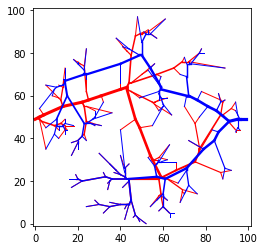

In [22]:
if use_widget:
    %matplotlib widget
fig = plt.figure('Vasculatura gerada')
ax = setup_plot(fig, L, N_mesh)
plot_vasculature(segments_in, nodes_in, flows_in, color='red')
plot_vasculature(segments_out, nodes_out, flows_out, color='blue')

## Referências bibliográficas

- PORTER, David. Generating Blood Vasculature for Bioheat Computations. In: PORTER, David. Theory and Applications of Heat Transfer in Humans. Chichester, UK: John Wiley & Sons Ltd, 2018. p. 33-51. ISBN 9781119127420. Disponível em: https://doi.org/10.1002/9781119127420.ch4. Acesso em: 01 jun. 2023.